In [1]:
import chess
import chess.engine
import random
import numpy as np
import pandas as pd
from stockfish import Stockfish 
from numpy import load
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers 
import tensorflow.keras.callbacks as callbacks
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks


In [27]:
def get_dataset():
    container = np.load('dataset\dataset.npz')
    b, v = container['b'], container['v']
    v = np.asarray(v/abs(v).max()/2+.5, dtype=np.float32)
    return b, v
xtrain, ytrain = get_dataset()


(1500000, 14, 8, 8)
[-5350 -5737 -6336 ...  -107   396   598]


# Data Methods

We define a random board and our engine to evaluate boardstates, we then split the boards into 3 dimensions like:

* WHITE: Pawns, Knights, Bishops, Rooks, Queens, King (6)

* BLACK: Pawns, Knights, Bishops, Rooks, Queens, King (6)

* White's Attack Squares (1)

* Black's Attack Squares (1)

Which ends up being (14,8,8) dimensionally


In [2]:
def random_board(depth):
    board = chess.Board()
    
    for _ in range(depth):
        all_moves = list(board.legal_moves)
        random_move = random.choice(all_moves)
        board.push(random_move)
        if board.is_game_over():
            break
    return board

#function score
def stockfish(board, depth):
    with chess.engine.SimpleEngine.popen_uci('C:\\Users\\coope\\Downloads\\Python\\Machine Learning\\Chess AI\\stockfish_15_win_x64_avx2\\stockfish_15_x64_avx2.exe') as sf:
        result = sf.analyse(board, chess.engine.Limit(depth = depth))
        score = result['score'].white().score()
        return score


In [5]:
stockfish(random_board(1), 1)

-35

In [21]:

squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}



# example: h3 -> 17
def square_to_index(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # create empty 3d matrix for each color's pieces
    board3d = np.zeros((14, 8, 8), dtype=np.int8)
  # 1 or 0 for pieces's view on the matrix, 
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
            idx = np.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # addding attacks and valid moves, use chess package
  # can't have a dumb AI 
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[12][i][j] = 1
        board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux

    return board3d




In [5]:
board

NameError: name 'board' is not defined

# Only run if you want your own dataset

In [35]:
def get_data(turns):
    boards = []
    evals = []
    board3d = []
    for turn in range(0, turns):
        board_new = random_board(np.mod(turn, 20)+1)
        boards.append(board_new)
        evals.append(stockfish(board_new, 5))
        board3d.append(split_dims(board_new))
    evals = pd.DataFrame(evals)
    return boards, evals, board3d

#data = get_data(100000)

#np.save('boards', data[0])
#np.save('boards3d3', data[2])
#np.save('eval3', data[1])

xtrain = np.load('boards3d3.npy')
print(xtrain.shape)
ytrain = np.load('eval3.npy')
ytrain = np.round(ytrain.astype(int))
print(ytrain)
print(ytrain.shape)

(100000, 14, 8, 8)
[[        -88]
 [          1]
 [       -138]
 ...
 [-2147483648]
 [       -782]
 [        630]]
(100000, 1)


# Convolutional Neural Network

def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, 'relu')(x)
    x = layers.Dense(1, 'relu')(x)

    return models.Model(inputs=board3d, outputs=x)

model = build_model(32, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

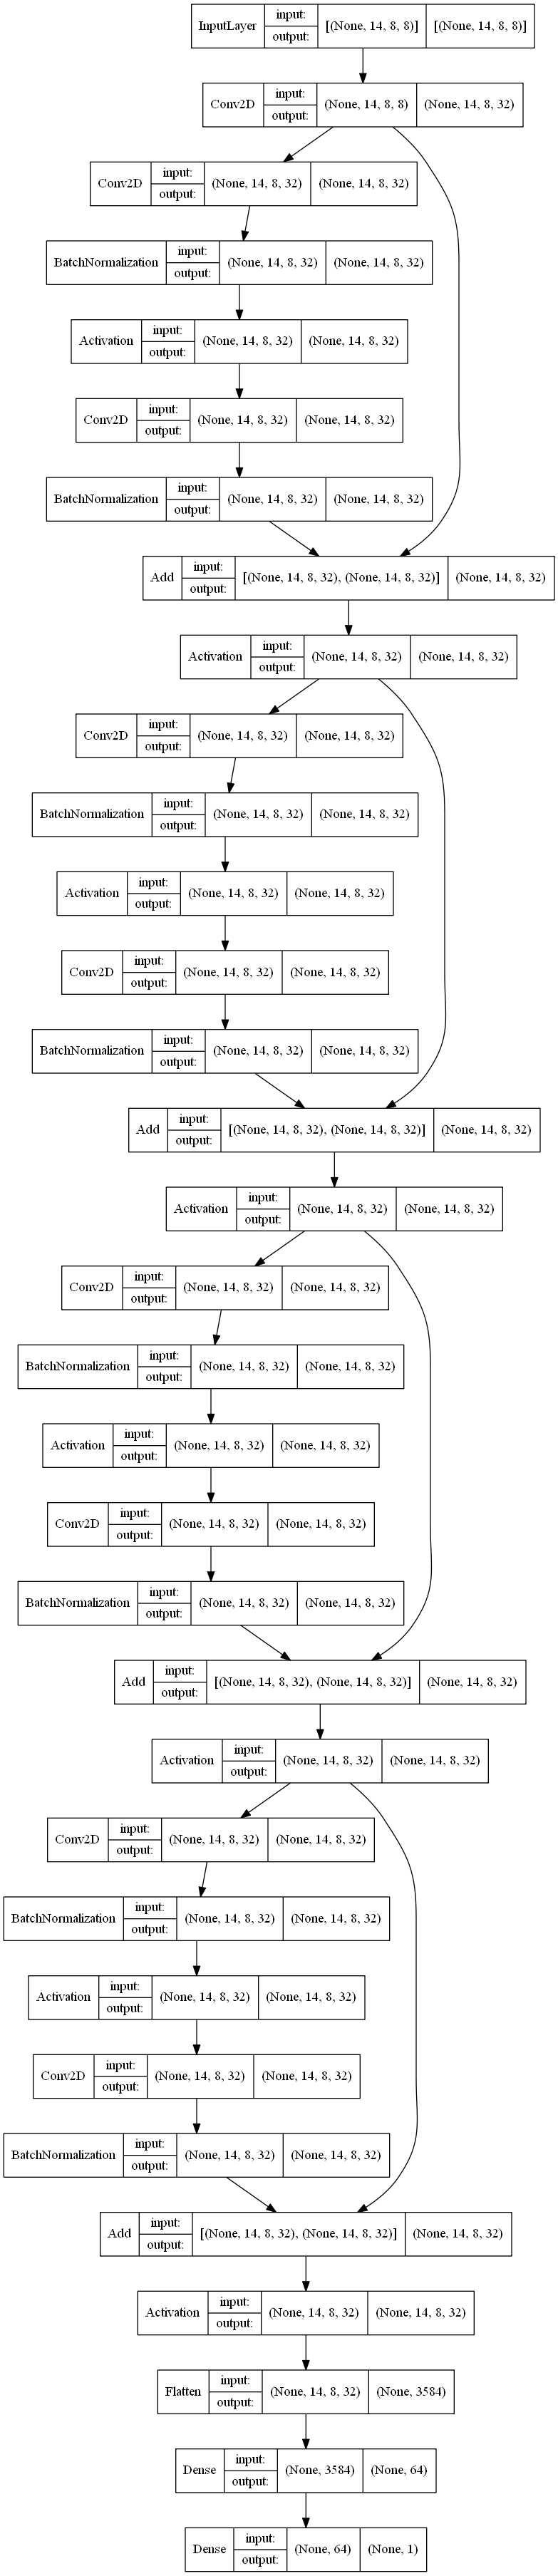

In [36]:
def build_model(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(board3d)
    for _ in range(conv_depth):
        previous = x
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, previous])
        x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64,'sigmoid')(x)
    x = layers.Dense(1, 'sigmoid')(x)

    return models.Model(inputs=board3d, outputs=x)

model = build_model(32, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

# Compiling and fitting model


In [37]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
model.fit(xtrain, ytrain,
          batch_size=512,
          epochs=50,
          verbose=2,
          validation_steps=1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
          callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=0.0000001)]
         )
model.save('model5.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 14, 8, 32)    2336        ['input_2[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 8, 32)    9248        ['conv2d_9[0][0]']               
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 14, 8, 32)   128         ['conv2d_10[0][0]']              
 rmalization)                                                                               

__________________________________________________________________________________________________
Epoch 1/50
196/196 - 70s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 70s/epoch - 359ms/step
Epoch 2/50
196/196 - 67s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 67s/epoch - 341ms/step
Epoch 3/50
196/196 - 72s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 72s/epoch - 370ms/step
Epoch 4/50
196/196 - 74s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 74s/epoch - 378ms/step
Epoch 5/50
196/196 - 75s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 75s/epoch - 385ms/step
Epoch 6/50
196/196 - 75s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 75s/epoch - 383ms/step
Epoch 7/50
196/196 - 76s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 76s/epoch - 388ms/step
Epoch 8/50
196/196 - 78s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 78s/epoch - 396ms/step
Epoch 9/50
196/196 - 88s - loss: 31267230918377472.0000 - lr: 5.0000e-04 - 88s/epoch - 450ms/step
Epoch 10/50
196/196